In [50]:
import numpy as np
import pandas as pd
import keras as k
from datetime import datetime

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = (10,10)
rcParams["lines.linewidth"] = 2 
plt.style.use("ggplot")

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional,Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error


In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

import warnings
warnings.filterwarnings('ignore')

In [54]:
#loading from the file
df = pd.read_csv('Bitcoin Gold.csv')
#checking the data - first and last 5
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Currency'], dtype='object')

In [55]:
df.head(20)

Date        Open        High         Low       Close       Volume  \
0   2017-11-09  140.514008  156.664993  138.231003  156.664993   13140500.0   
1   2017-11-10  157.490005  213.403000  155.391998  213.403000   36198500.0   
2   2017-11-11  213.123993  509.811005  213.123993  427.135010  187191008.0   
3   2017-11-12  421.750000  465.618011  281.545013  282.407013   90339904.0   
4   2017-11-13  277.002991  307.259003  218.339005  249.220993   45916500.0   
5   2017-11-14  253.214996  253.214996  154.052002  159.940994   39340400.0   
6   2017-11-15  160.539001  187.278000  151.466003  161.690994   30094100.0   
7   2017-11-16  161.871994  181.330002  136.395004  140.776993   27949200.0   
8   2017-11-17  138.751007  165.934998  133.048004  152.020004   24935100.0   
9   2017-11-18  153.072006  172.449997  151.787003  155.727005   24642900.0   
10  2017-11-19  154.914993  155.548004  133.962006  135.686005   19503400.0   
11  2017-11-20  135.197006  247.102005  105.788002  236.373001   93826896.0   
12  2017-11-21  250.850998  364.782990  201.895996  267.208008  370782016.0   
13  2017-11-22  264.182007  275.053009  232.916000  241.723999  111451000.0   
14  2017-11-23  241.970993  299.894012  241.970993  293.613007  154038000.0   
15  2017-11-24  295.752991  413.743988  284.259003  394.217987  537472000.0   
16  2017-11-25  394.042999  394.042999  339.101013  356.036987  208662000.0   
17  2017-11-26  355.721985  366.786011  334.742004  366.786011  141228000.0   
18  2017-11-27  370.178009  387.881012  353.666992  359.244995  129160000.0   
19  2017-11-28  359.355011  360.119995  325.559998  329.783997  101004000.0   

   Currency  
0       USD  
1       USD  
2       USD  
3       USD  
4       USD  
5       USD  
6       USD  
7       USD  
8       USD  
9       USD  
10      USD  
11      USD  
12      USD  
13      USD  
14      USD  
15      USD  
16      USD  
17      USD  
18      USD  
19      USD

# exploratory analysis

1. checking the data


In [56]:
#checking for null values in the data
df.isna().mean()

Date        0.0
Open        0.0
High        0.0
Low         0.0
Close       0.0
Volume      0.0
Currency    0.0
dtype: float64

In [8]:

from pandas_profiling import ProfileReport as Prt
profile = Prt(df, title="Report")
profile

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [57]:
#setting Date as index
df['Date'] = pd.to_datetime(df.Date, dayfirst=True)
df.set_index('Date', inplace=True)


In [58]:
# converting the TimeSeries to include time specified frequency and usinng backfill method
df = df.asfreq('d')
df = df.fillna(method = 'bfill')

2.Plotting the variables against time

Text(0.5, 1.0, 'Opening Price')

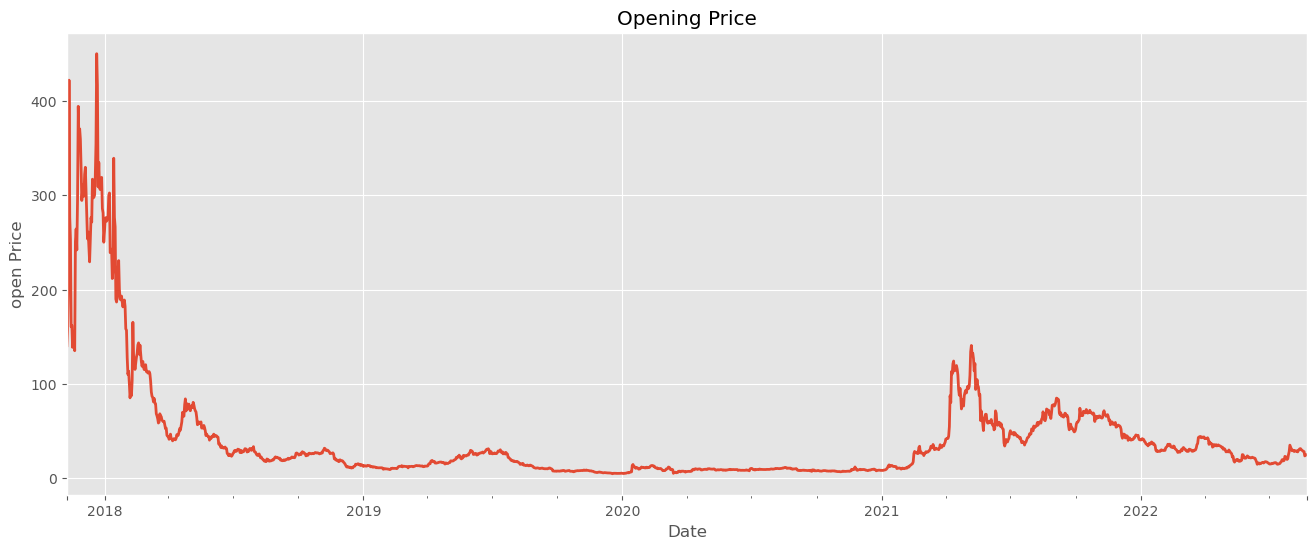

In [59]:
df['Open'].plot(figsize=(16,6))
plt.ylabel('open Price')
plt.title('Opening Price')

Text(0.5, 1.0, 'High Price')

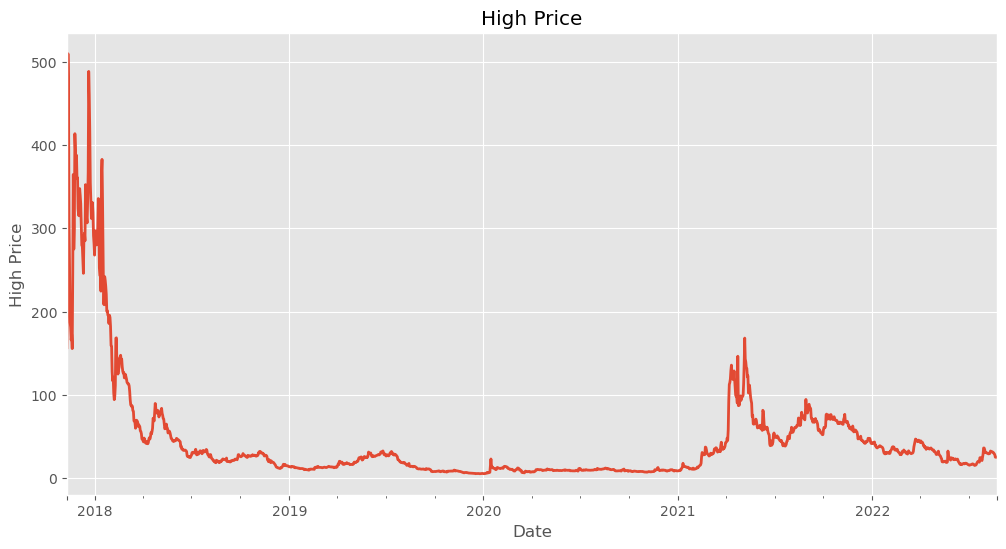

In [60]:
df['High'].plot(figsize=(12,6))
plt.ylabel('High Price')
plt.title('High Price')

Text(0.5, 1.0, 'Low Price')

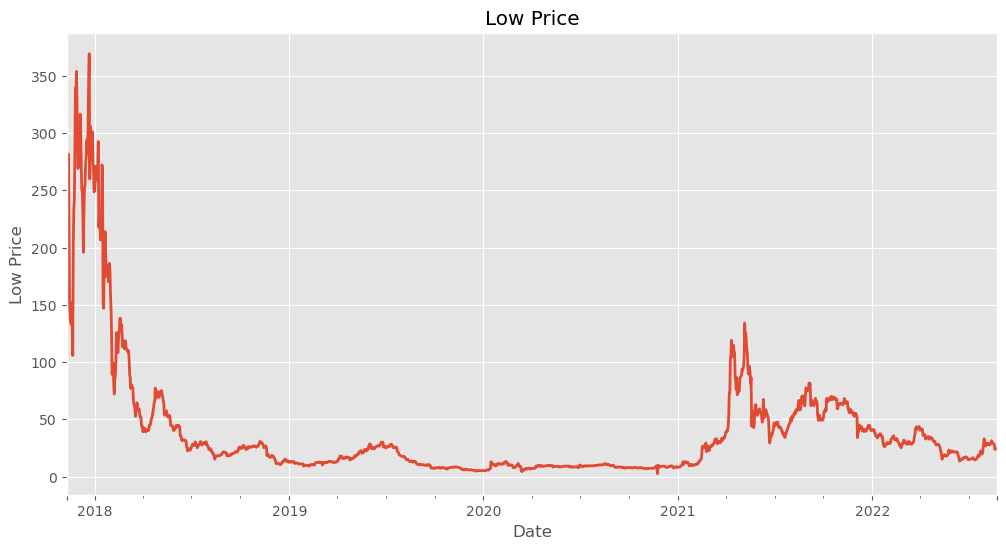

In [61]:
df['Low'].plot(figsize=(12,6))
plt.ylabel('Low Price')
plt.title('Low Price')

Text(0.5, 1.0, 'Closing Price')

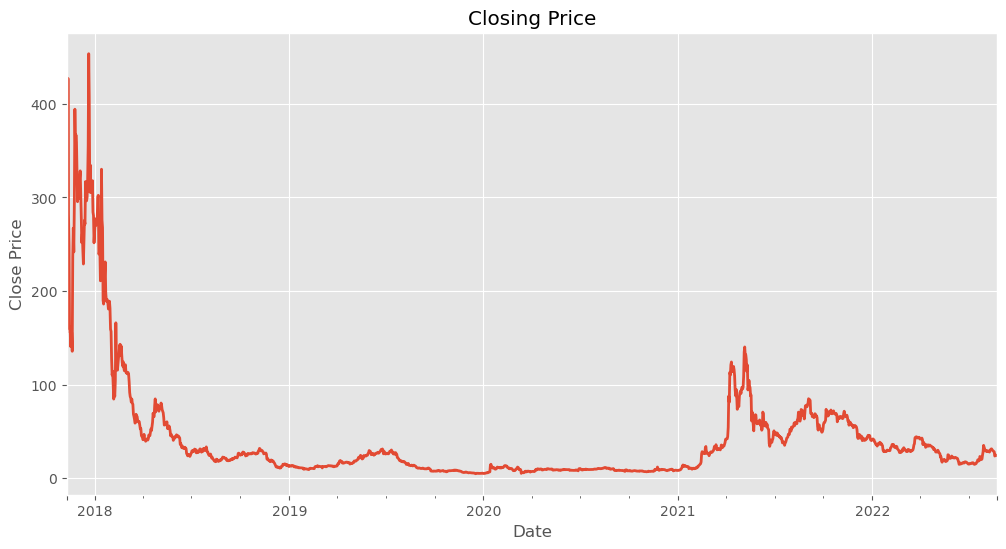

In [62]:
df['Close'].plot(figsize=(12,6))
plt.ylabel('Close Price')
plt.title('Closing Price')

Text(0.5, 1.0, 'Volume Price')

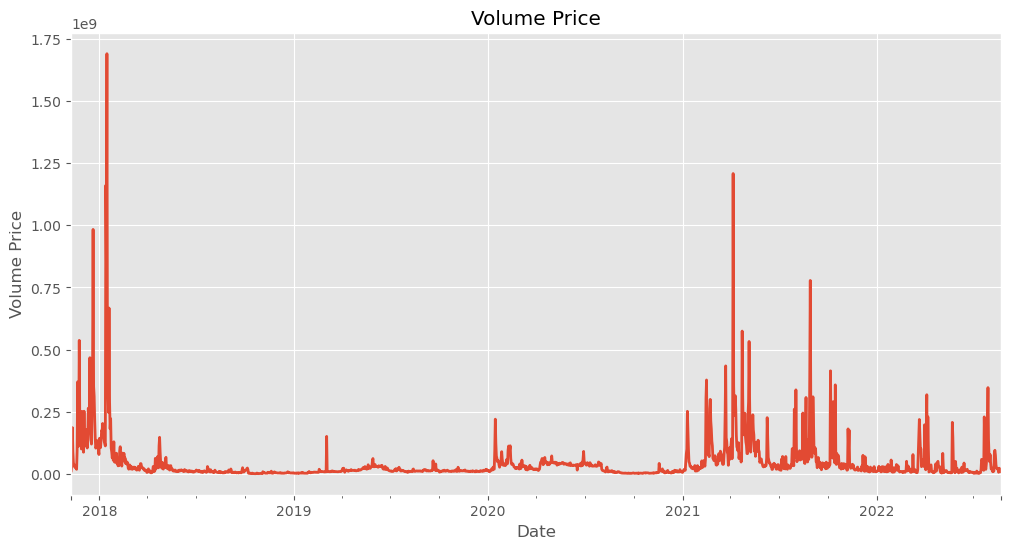

In [63]:
df['Volume'].plot(figsize=(12,6))
plt.ylabel('Volume Price')
plt.title('Volume Price')

In [64]:
df['Total Pov'] = df.sum(axis=1)

Text(0.5, 1.0, 'Total Portfolio Value')

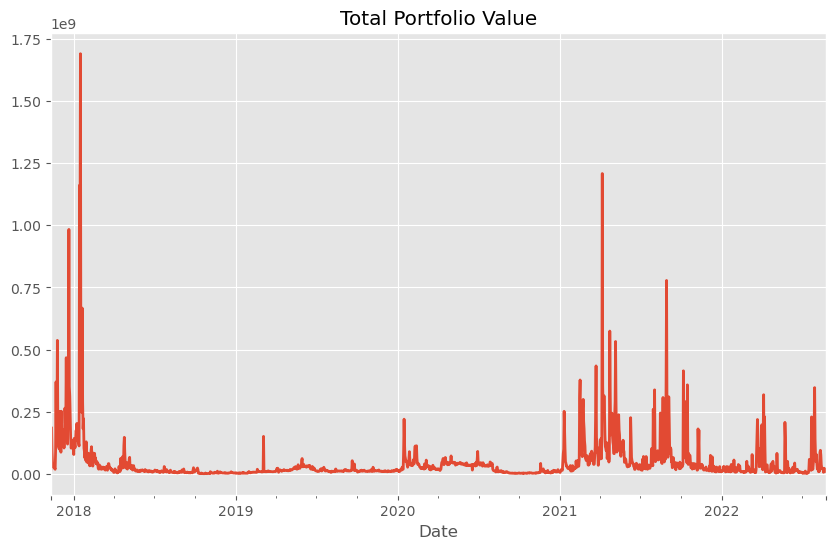

In [65]:
df['Total Pov'].plot(figsize=(10,6))
plt.title('Total Portfolio Value')

In [66]:
df['Daily Return'] = df['Total Pov'].pct_change(1)

In [67]:
df['Daily Return'].mean()

0.1860581918370679

<AxesSubplot:ylabel='Density'>

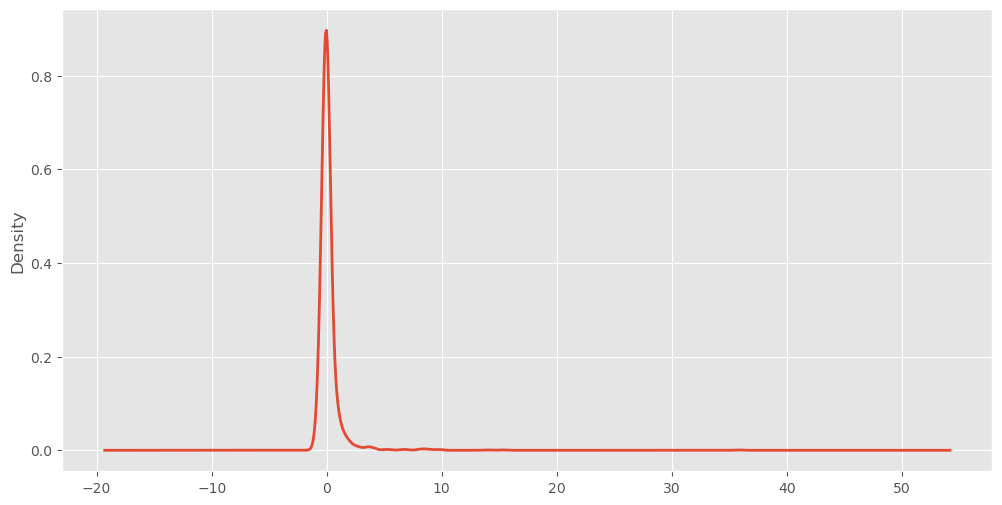

In [68]:
df['Daily Return'].plot(kind='kde', figsize=(12,6))

In [69]:
SR = df['Daily Return'].mean()/df['Daily Return'].std()
SR

0.13795630639848022

In [70]:
df = df.drop('Currency', axis=1)

<AxesSubplot:xlabel='Date'>

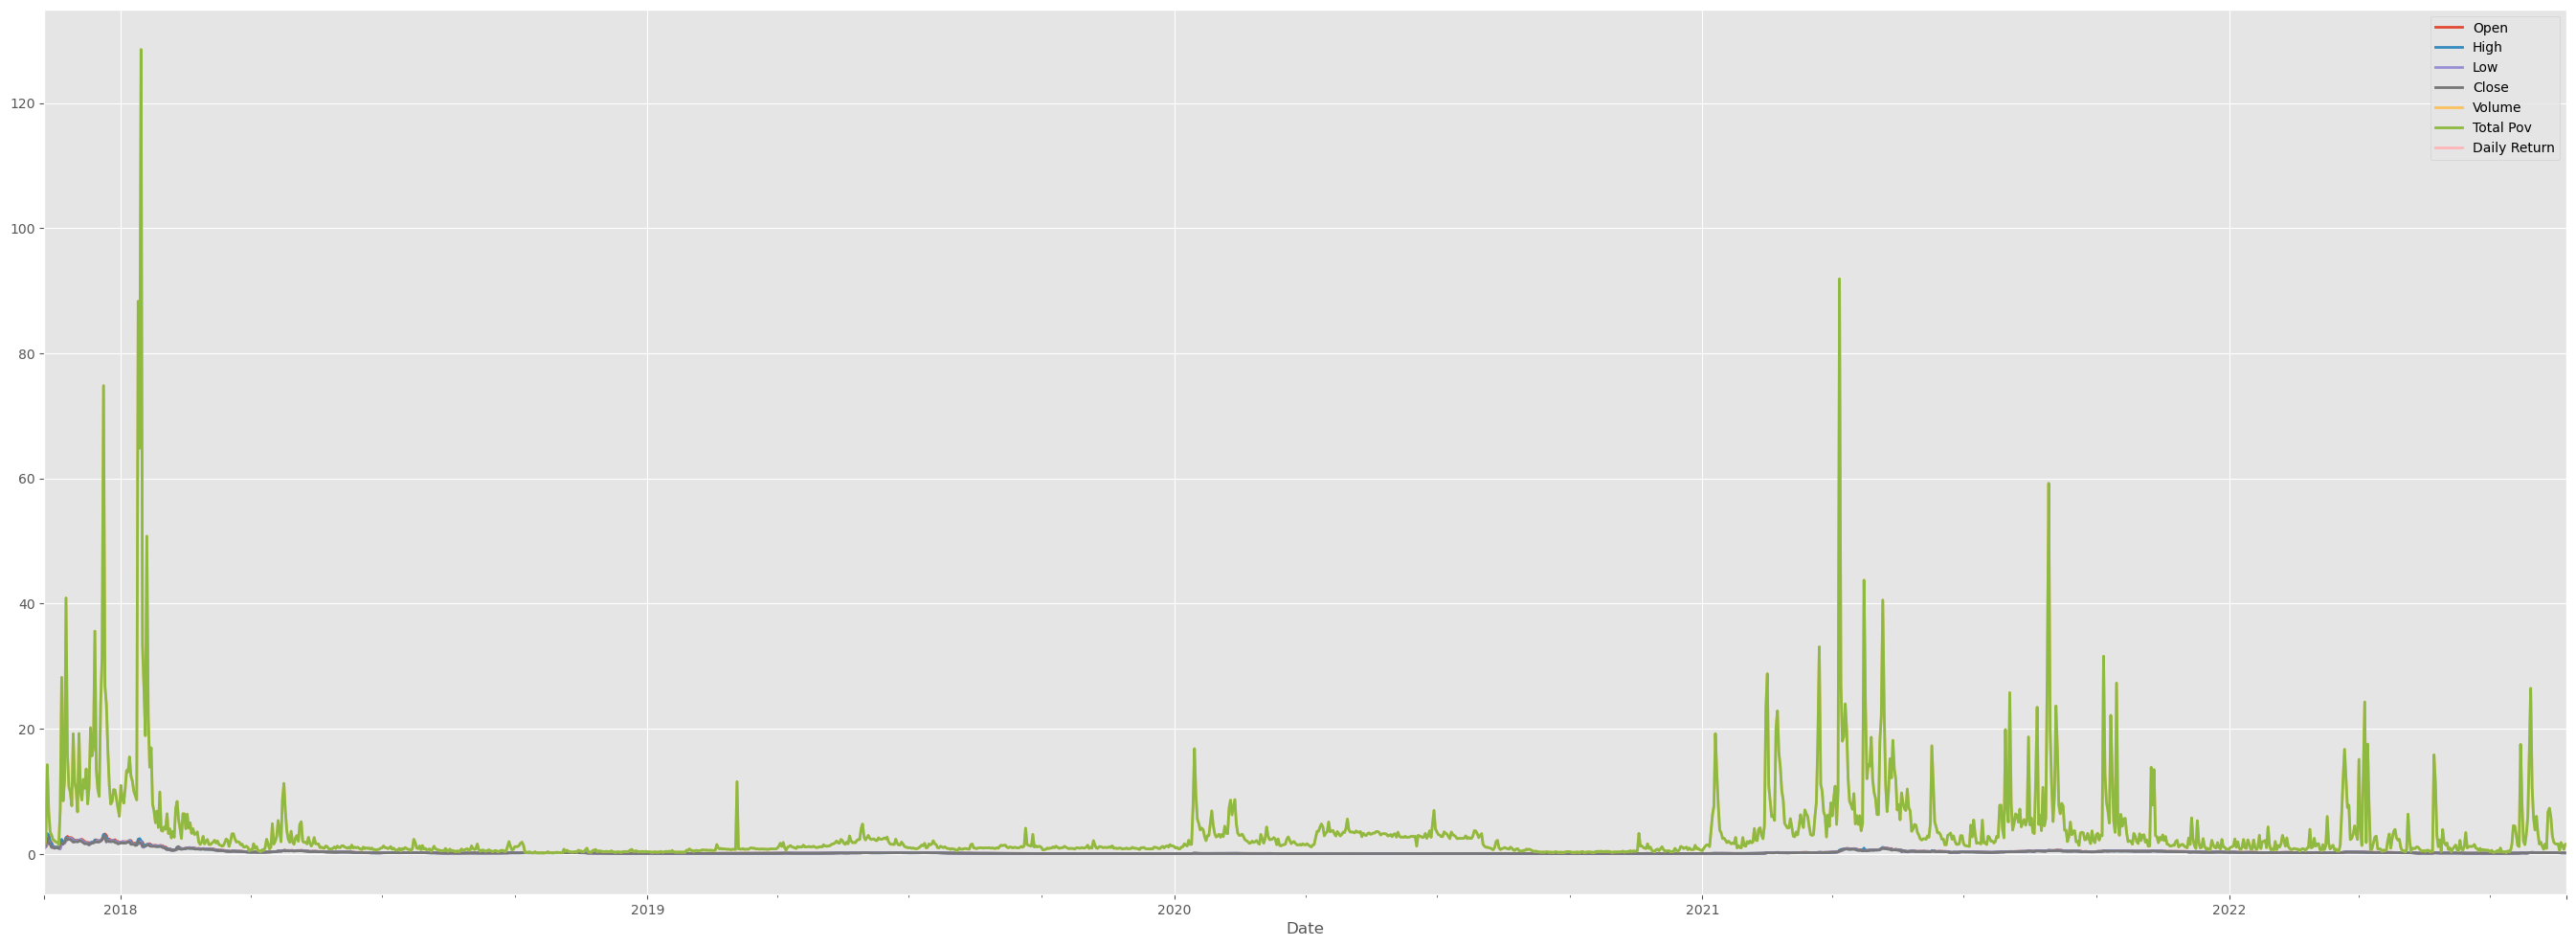

In [72]:
all_plt = df/df.iloc[0]
all_plt.plot(figsize=(34,12))

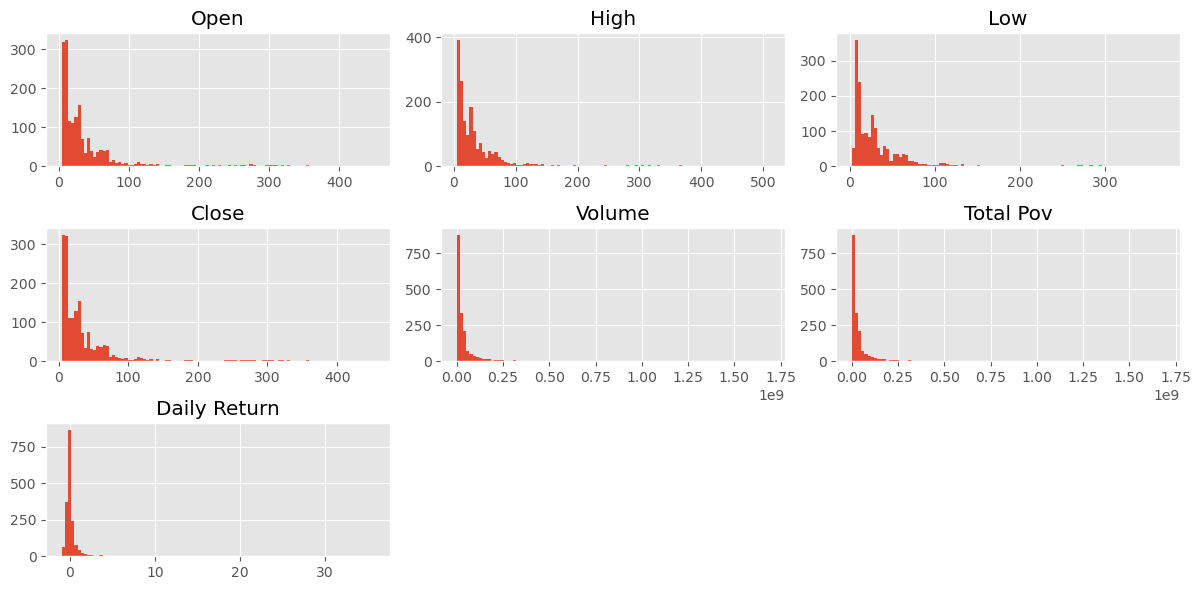

In [73]:
#3. histograms
df.hist(bins=100, figsize=(12,6));
plt.tight_layout()

In [74]:
df.resample(rule='A').mean()

Open        High         Low       Close        Volume  \
Date                                                                       
2017-12-31  281.447679  313.479679  254.968303  283.300849  1.761246e+08   
2018-12-31   59.504325   62.859098   55.585332   58.804762  3.911406e+07   
2019-12-31   14.440855   14.924827   13.989406   14.419816  1.499623e+07   
2020-12-31    9.096205    9.479982    8.749003    9.103864  2.681281e+07   
2021-12-31   53.584517   56.959785   50.620845   53.654878  8.439958e+07   
2022-12-31   28.246711   29.270079   27.332272   28.176719  3.234718e+07   

               Total Pov  Daily Return  
Date                                    
2017-12-31  1.761257e+08      0.317471  
2018-12-31  3.911429e+07      0.099900  
2019-12-31  1.499629e+07      0.068253  
2020-12-31  2.681284e+07      0.047344  
2021-12-31  8.439980e+07      0.268765  
2022-12-31  3.234729e+07      0.561354

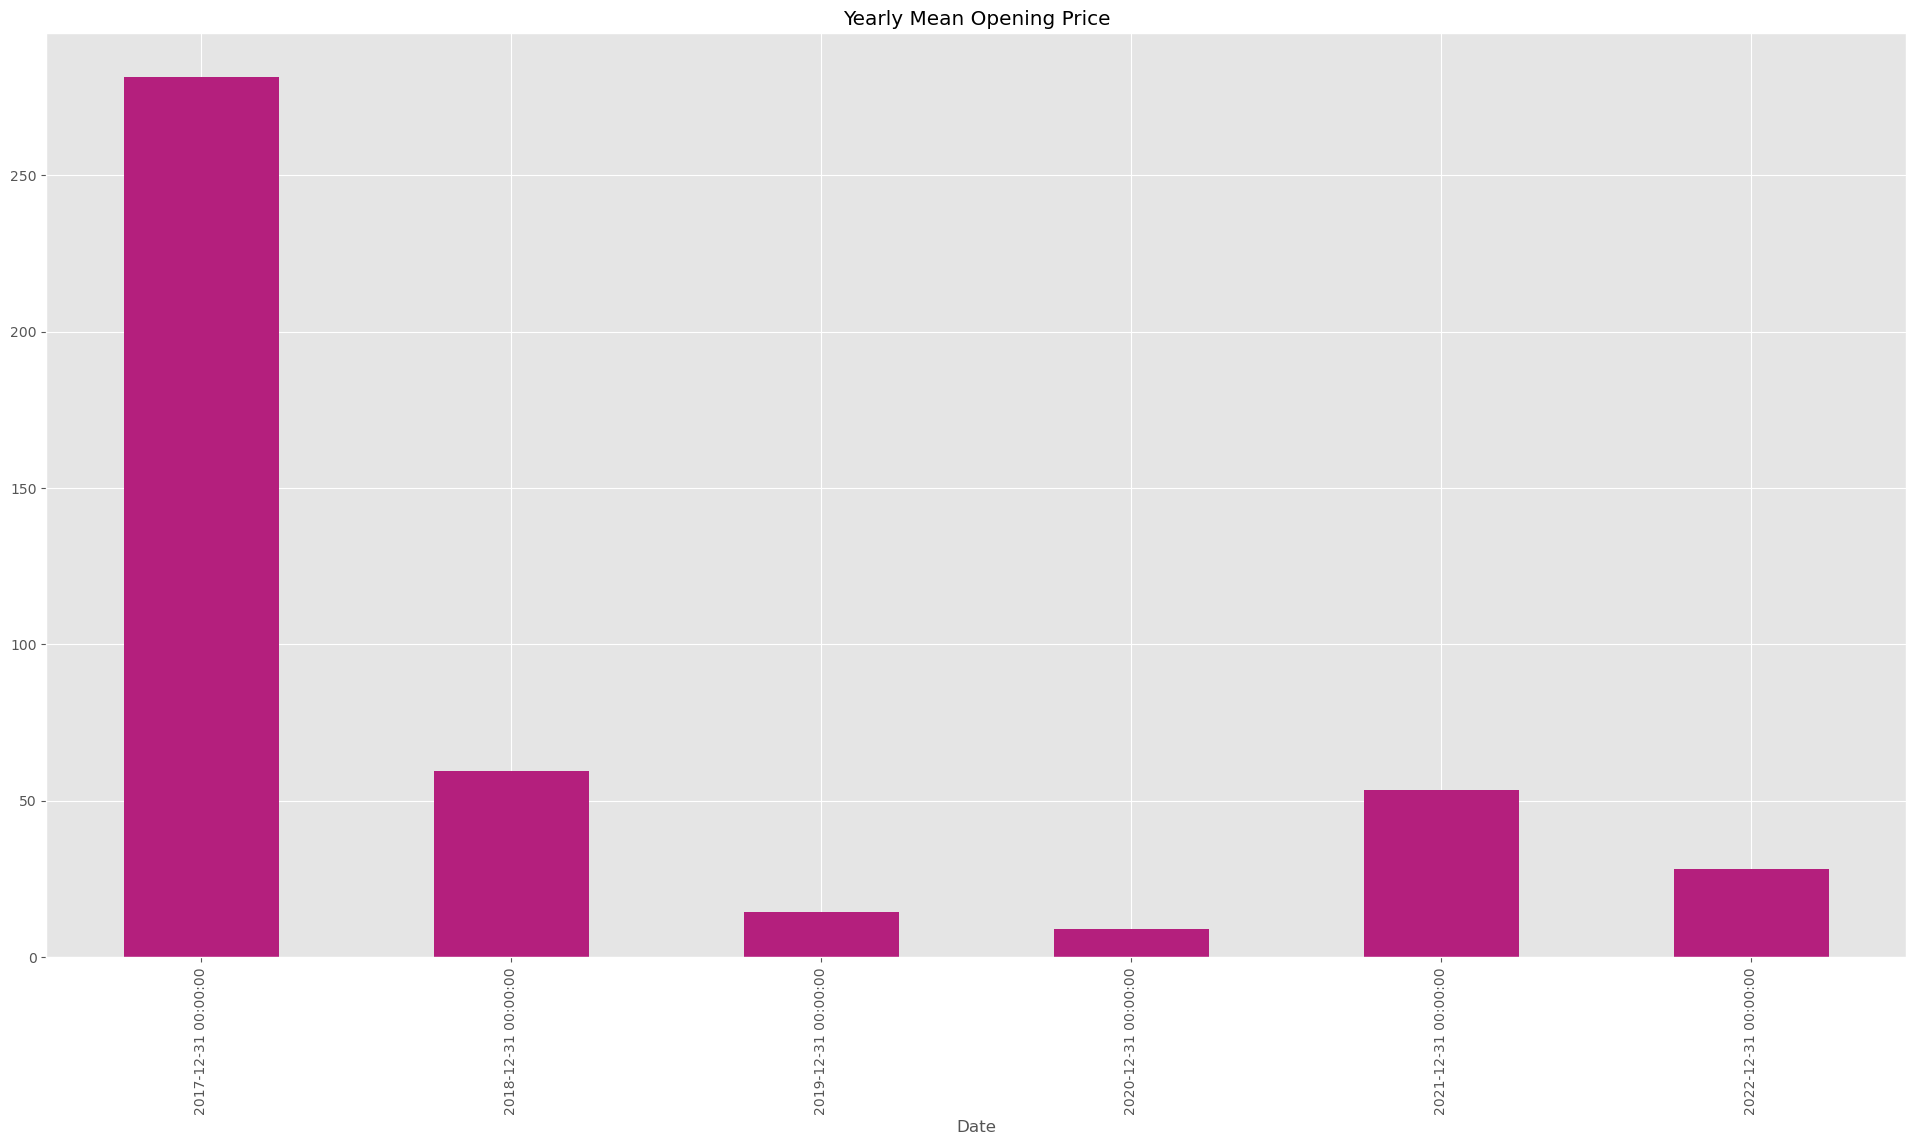

In [33]:
df['Open'].resample(rule='A').mean().plot.bar(title='Yearly Mean Opening Price', color=['#b41f7d'], figsize=(24,12));

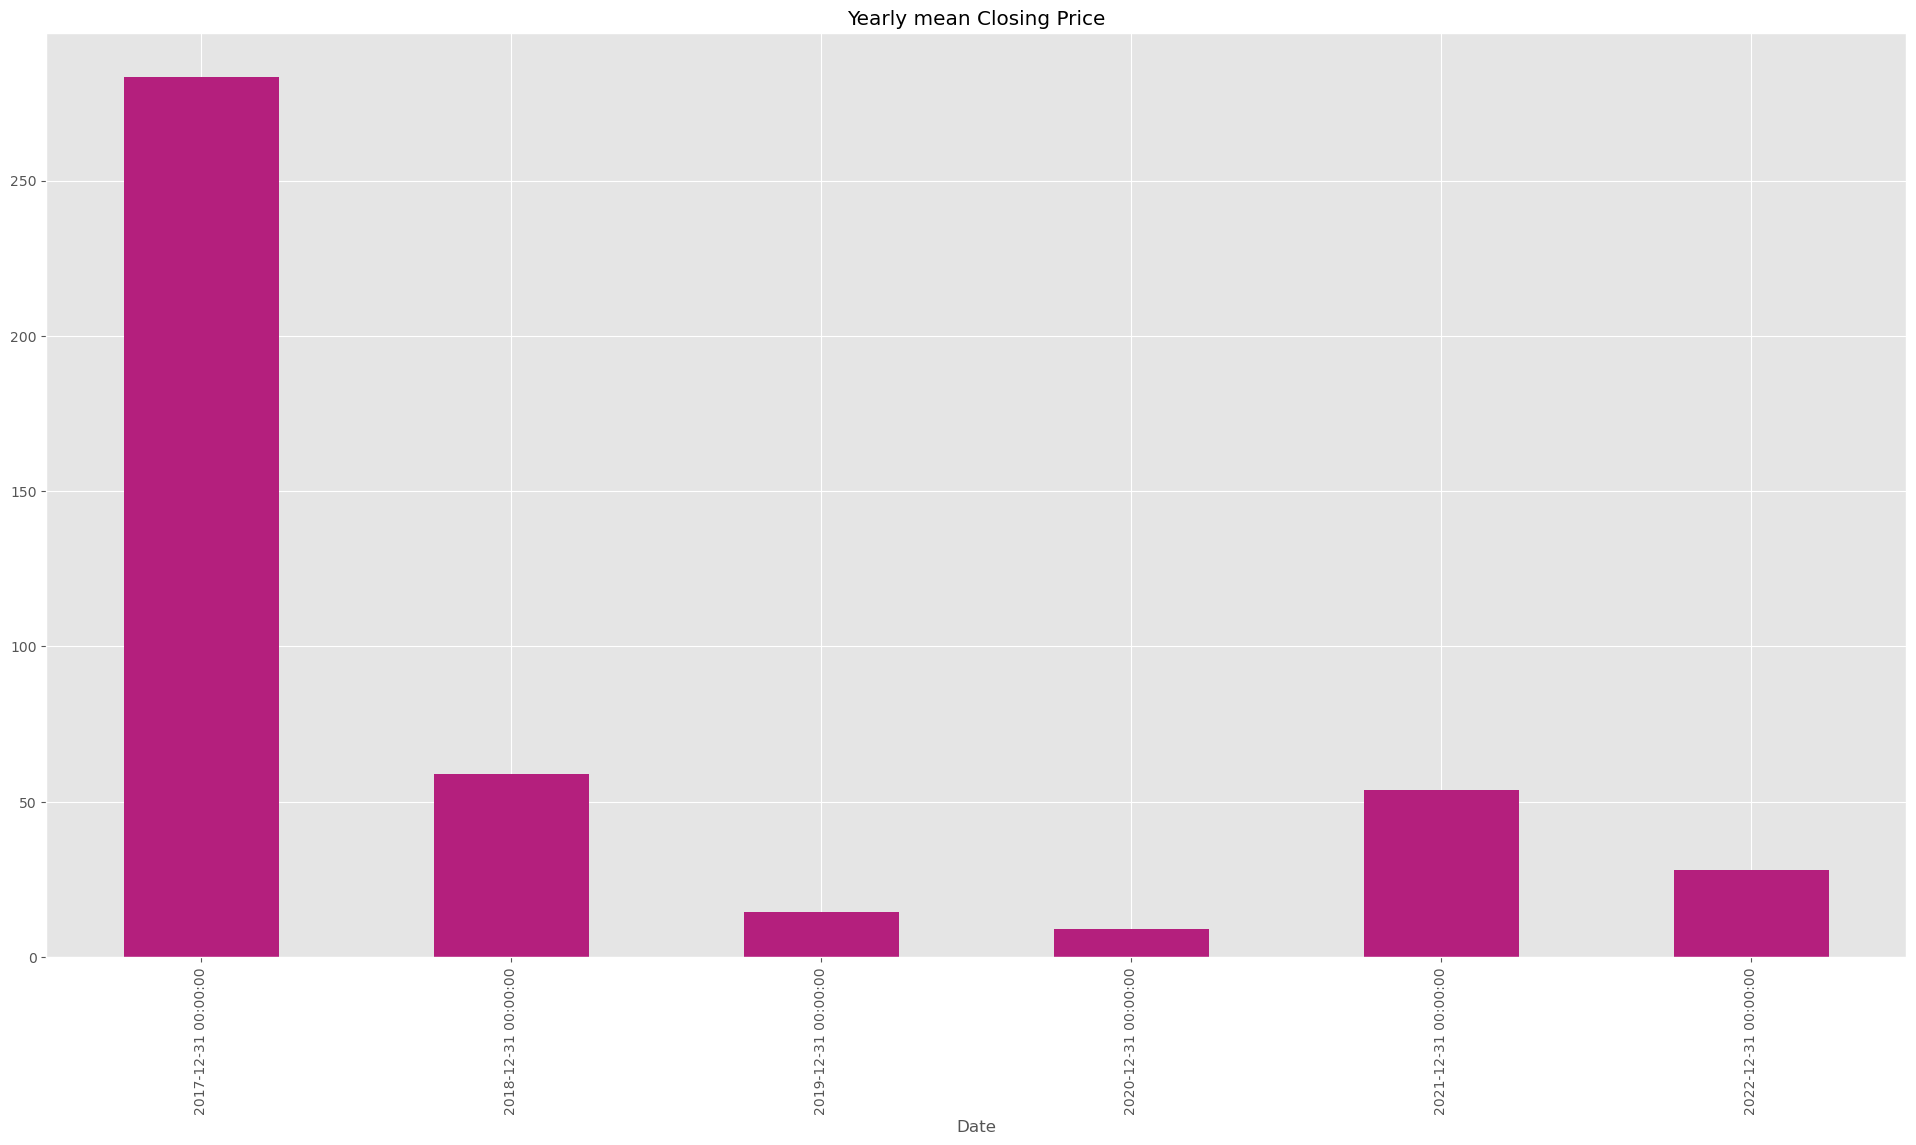

In [75]:
df['Close'].resample(rule='A').mean().plot.bar(title='Yearly mean Closing Price', color=['#b41f7d'],  figsize=(24,12));

In [78]:
df['6-month-SMA']  = df['Open'].rolling(window=6).mean()
df['12-month-SMA'] = df['Open'].rolling(window=12).mean()
df['2-month-SMA']  = df['Open'].rolling(window=2).mean()

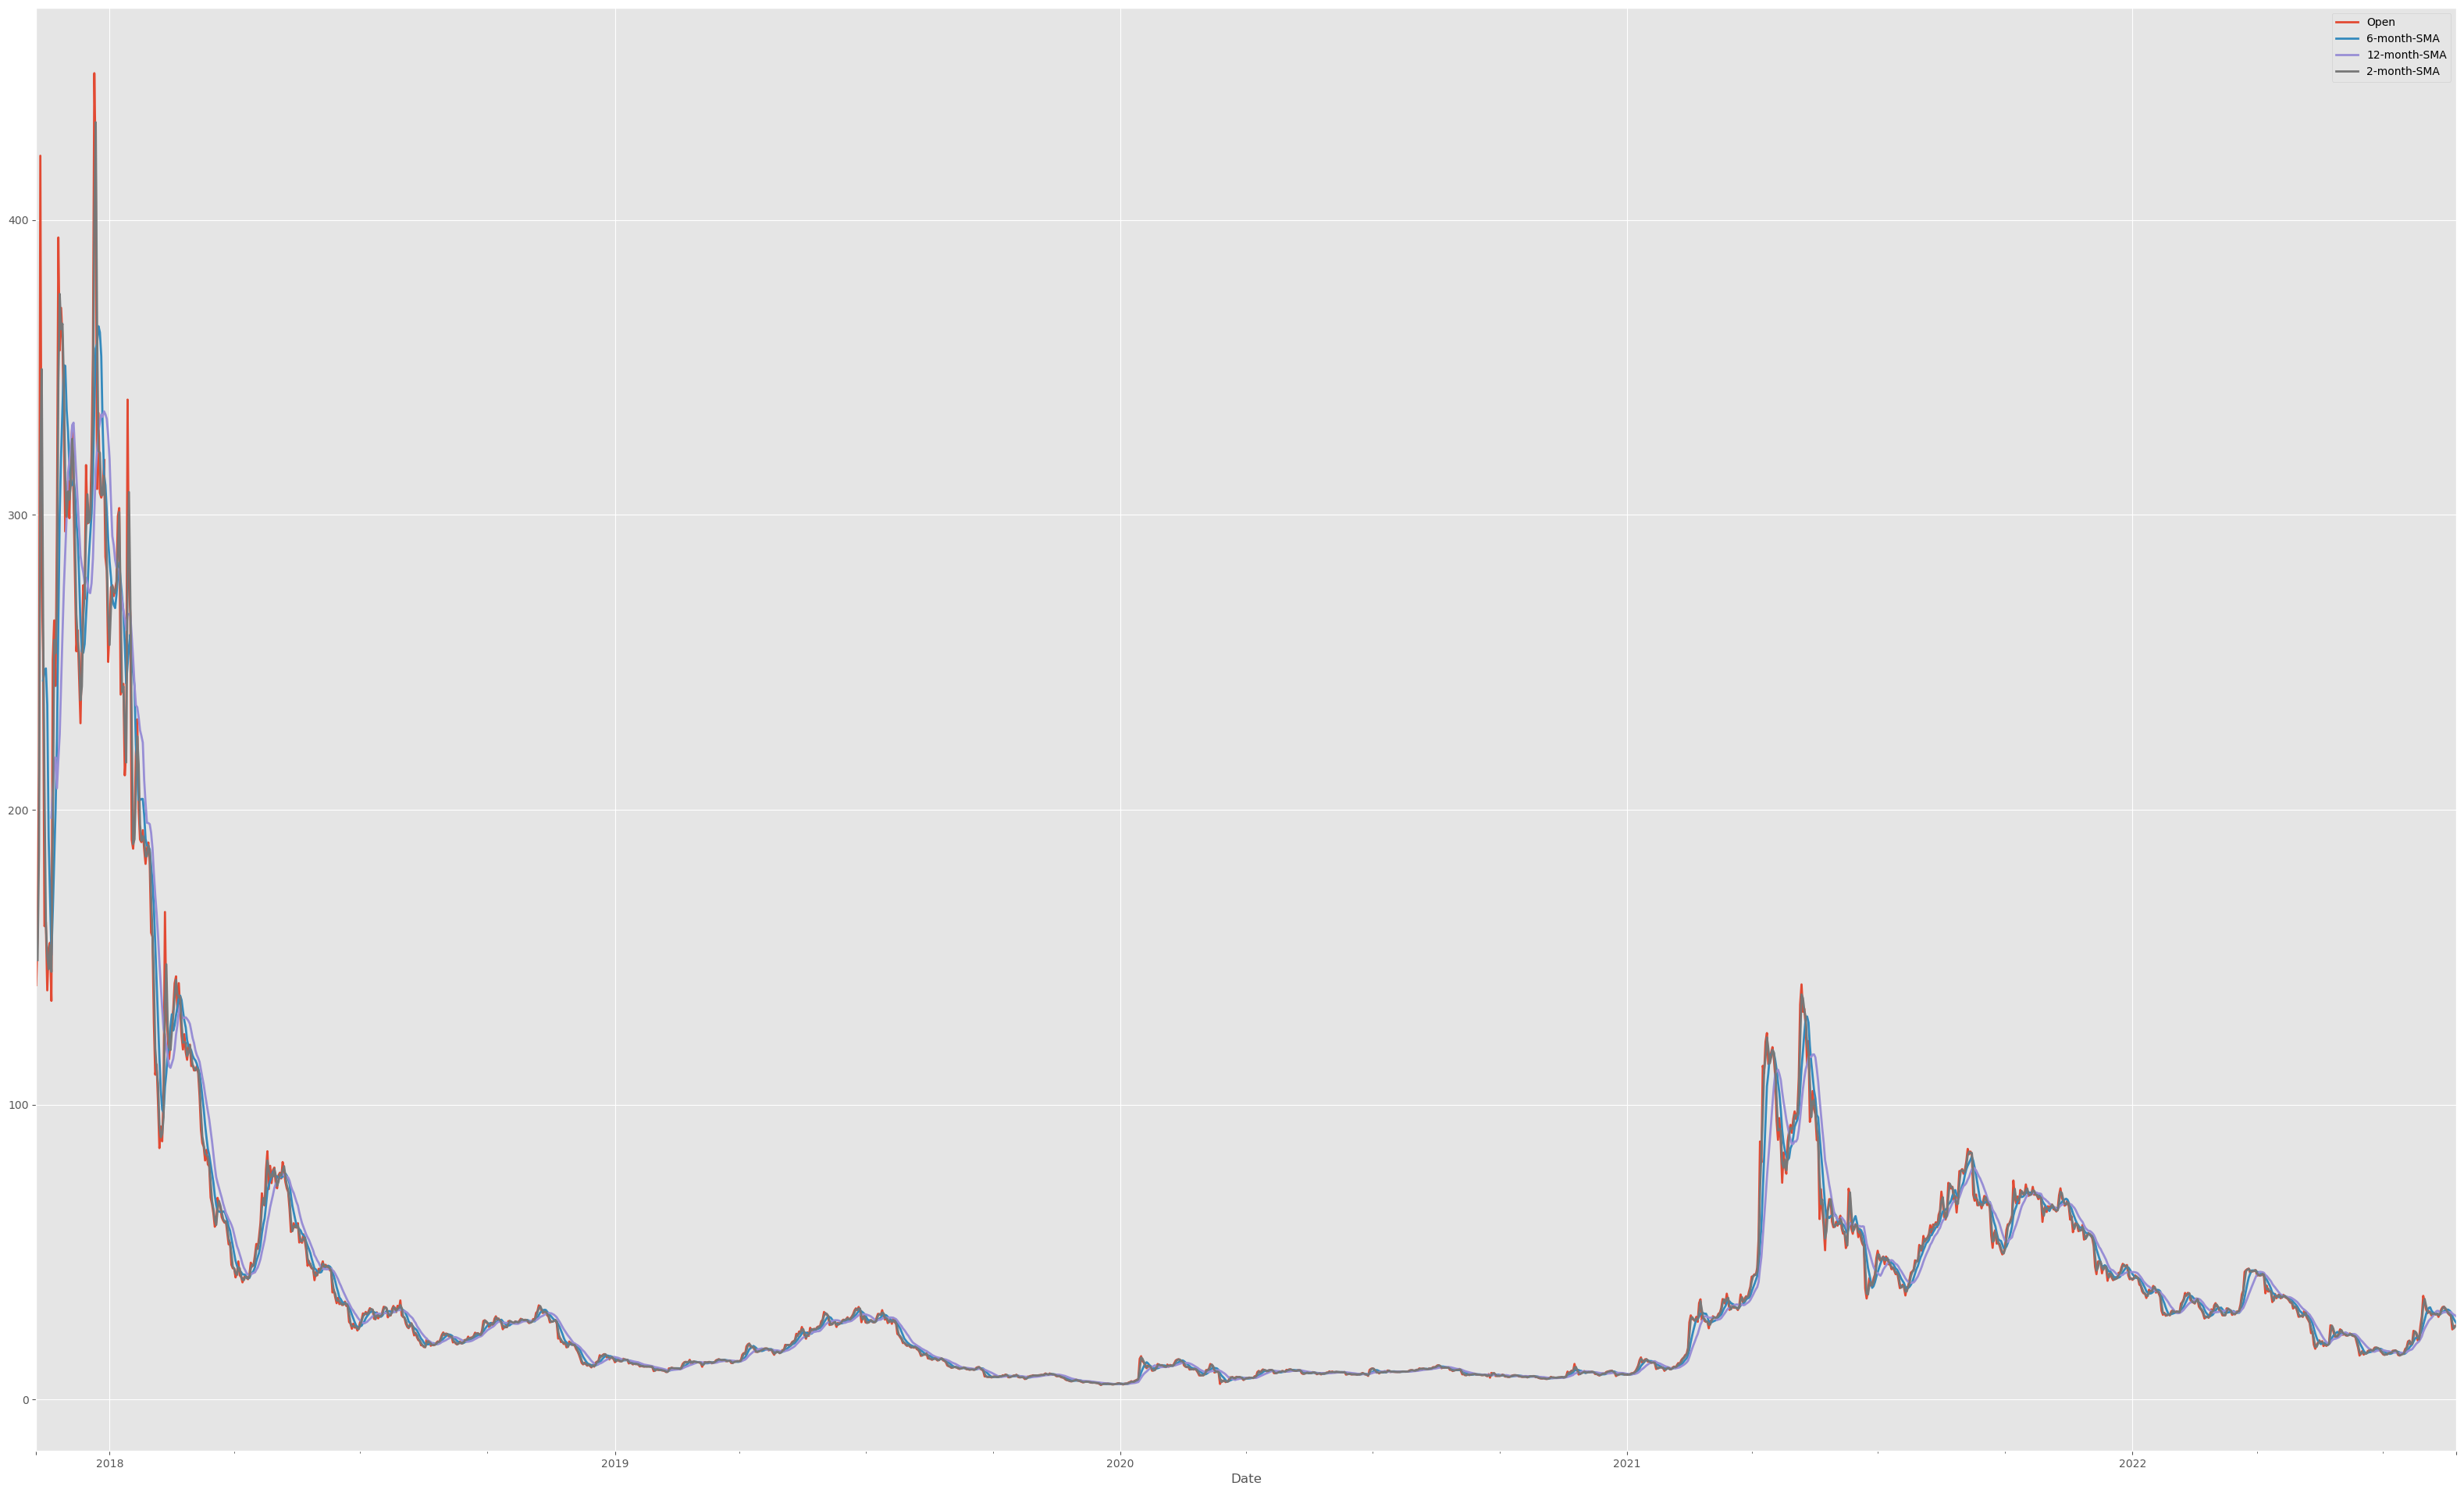

In [79]:
df[['Open', '6-month-SMA', '12-month-SMA', '2-month-SMA']].plot(figsize=(40,24));

<AxesSubplot:xlabel='Date'>

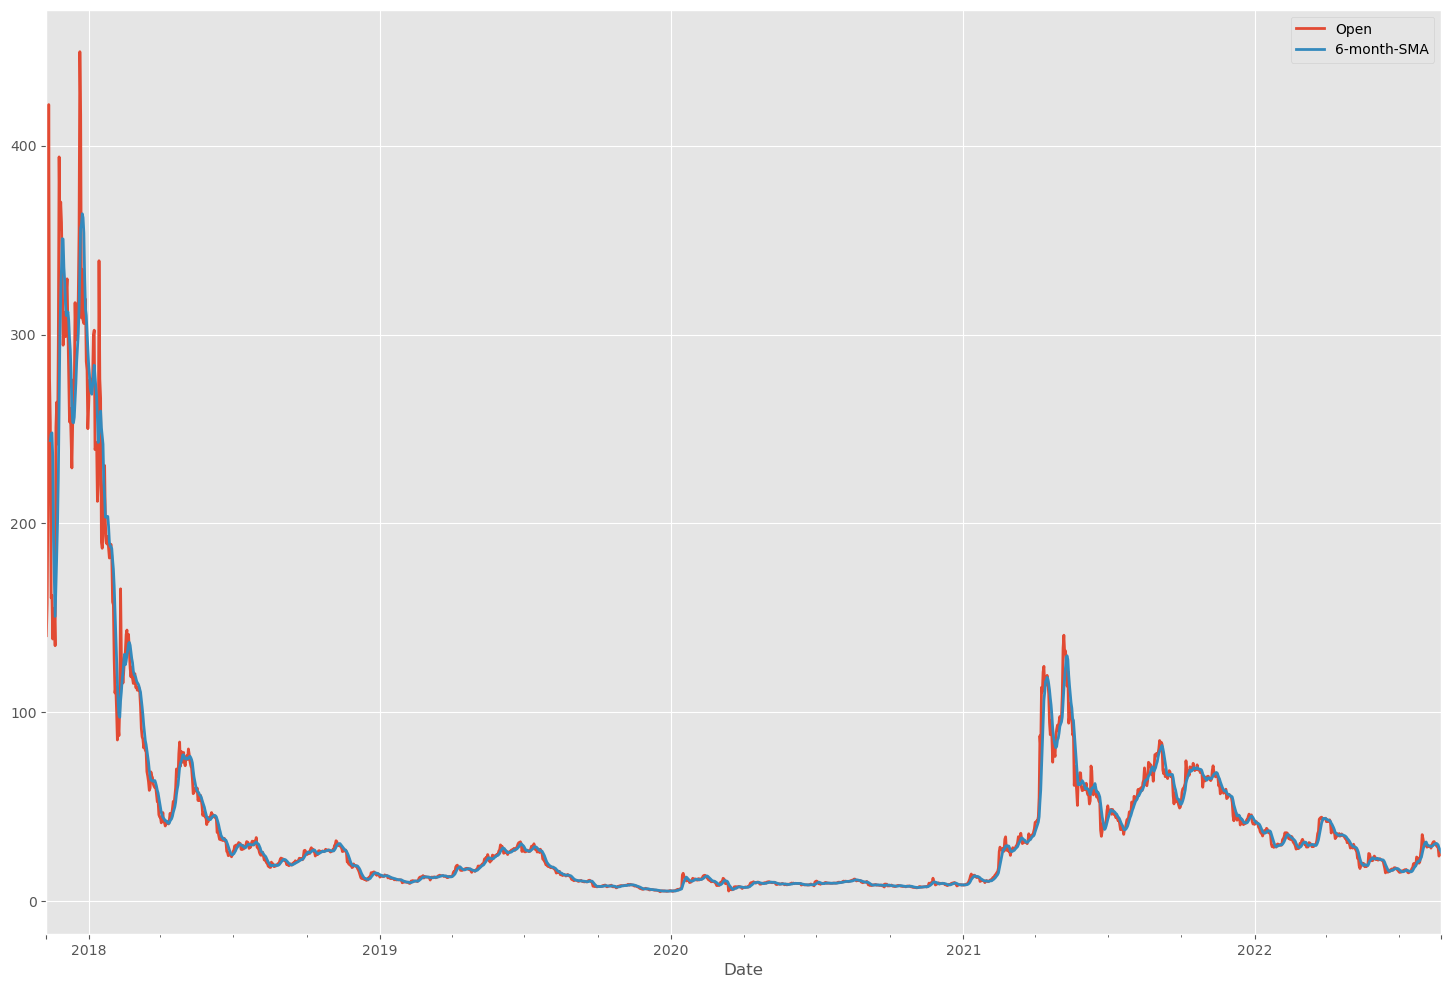

In [80]:
df[['Open','6-month-SMA']].plot(figsize=(18,12))

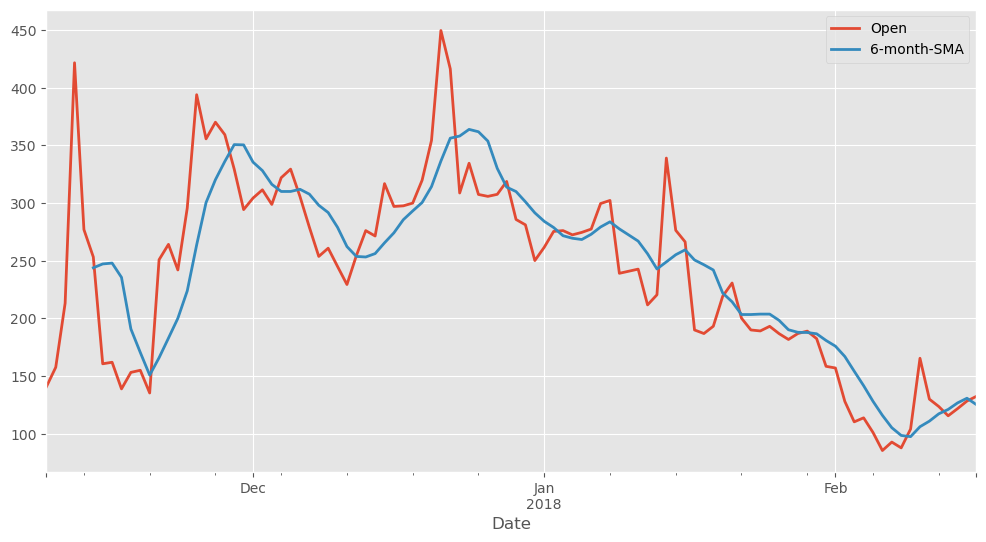

In [81]:
df[['Open', '6-month-SMA']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

In [82]:
df['EWM-A12'] = df['Open'].ewm(span=14, adjust=True).mean()

In [83]:
span = 8
alpha = 2/(span+1)

In [84]:
df['EWM-A12'] = df['Open'].ewm(alpha=alpha, adjust= False).mean()

In [85]:
model = SimpleExpSmoothing(df['Open'])

In [86]:
fitted_model = model.fit(smoothing_level = alpha, optimized = False)

In [87]:
#df[['Open', 'EWM-A12']].plot(figsize=(24,12));
fitted_model.fittedvalues

Date
2017-11-09    140.514008
2017-11-10    140.514008
2017-11-11    144.286452
2017-11-12    159.583683
2017-11-13    217.842865
                 ...    
2022-08-19     29.639007
2022-08-20     29.350887
2022-08-21     28.115179
2022-08-22     27.297107
2022-08-23     26.793639
Freq: D, Length: 1749, dtype: float64

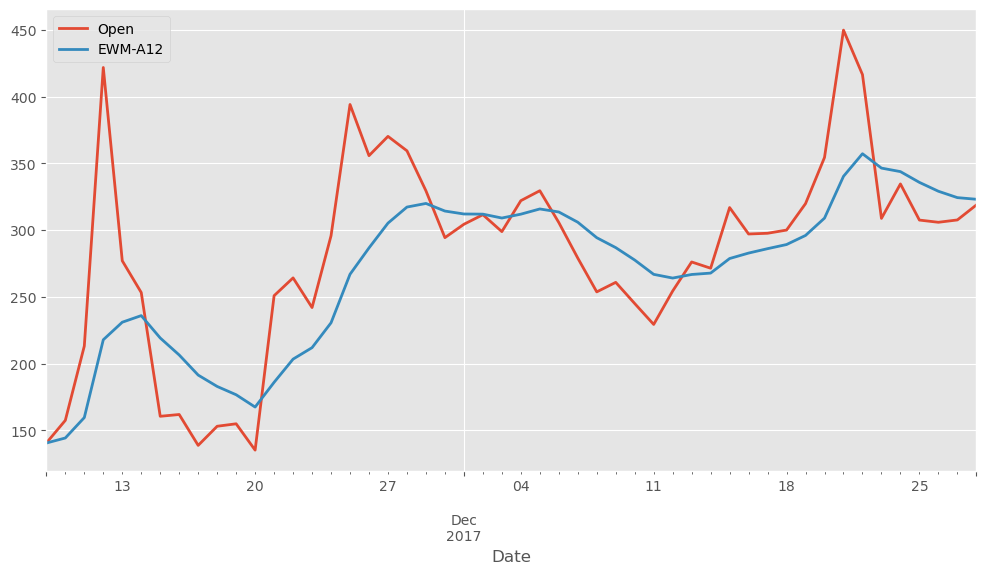

In [88]:
df[['Open','EWM-A12']].iloc[:50].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

In [89]:
fitted_model.fittedvalues.shift(-1)

Date
2017-11-09    140.514008
2017-11-10    144.286452
2017-11-11    159.583683
2017-11-12    217.842865
2017-11-13    230.989559
                 ...    
2022-08-19     29.350887
2022-08-20     28.115179
2022-08-21     27.297107
2022-08-22     26.793639
2022-08-23           NaN
Freq: D, Length: 1749, dtype: float64

In [90]:
df['SES12'] = fitted_model.fittedvalues.shift(-1)

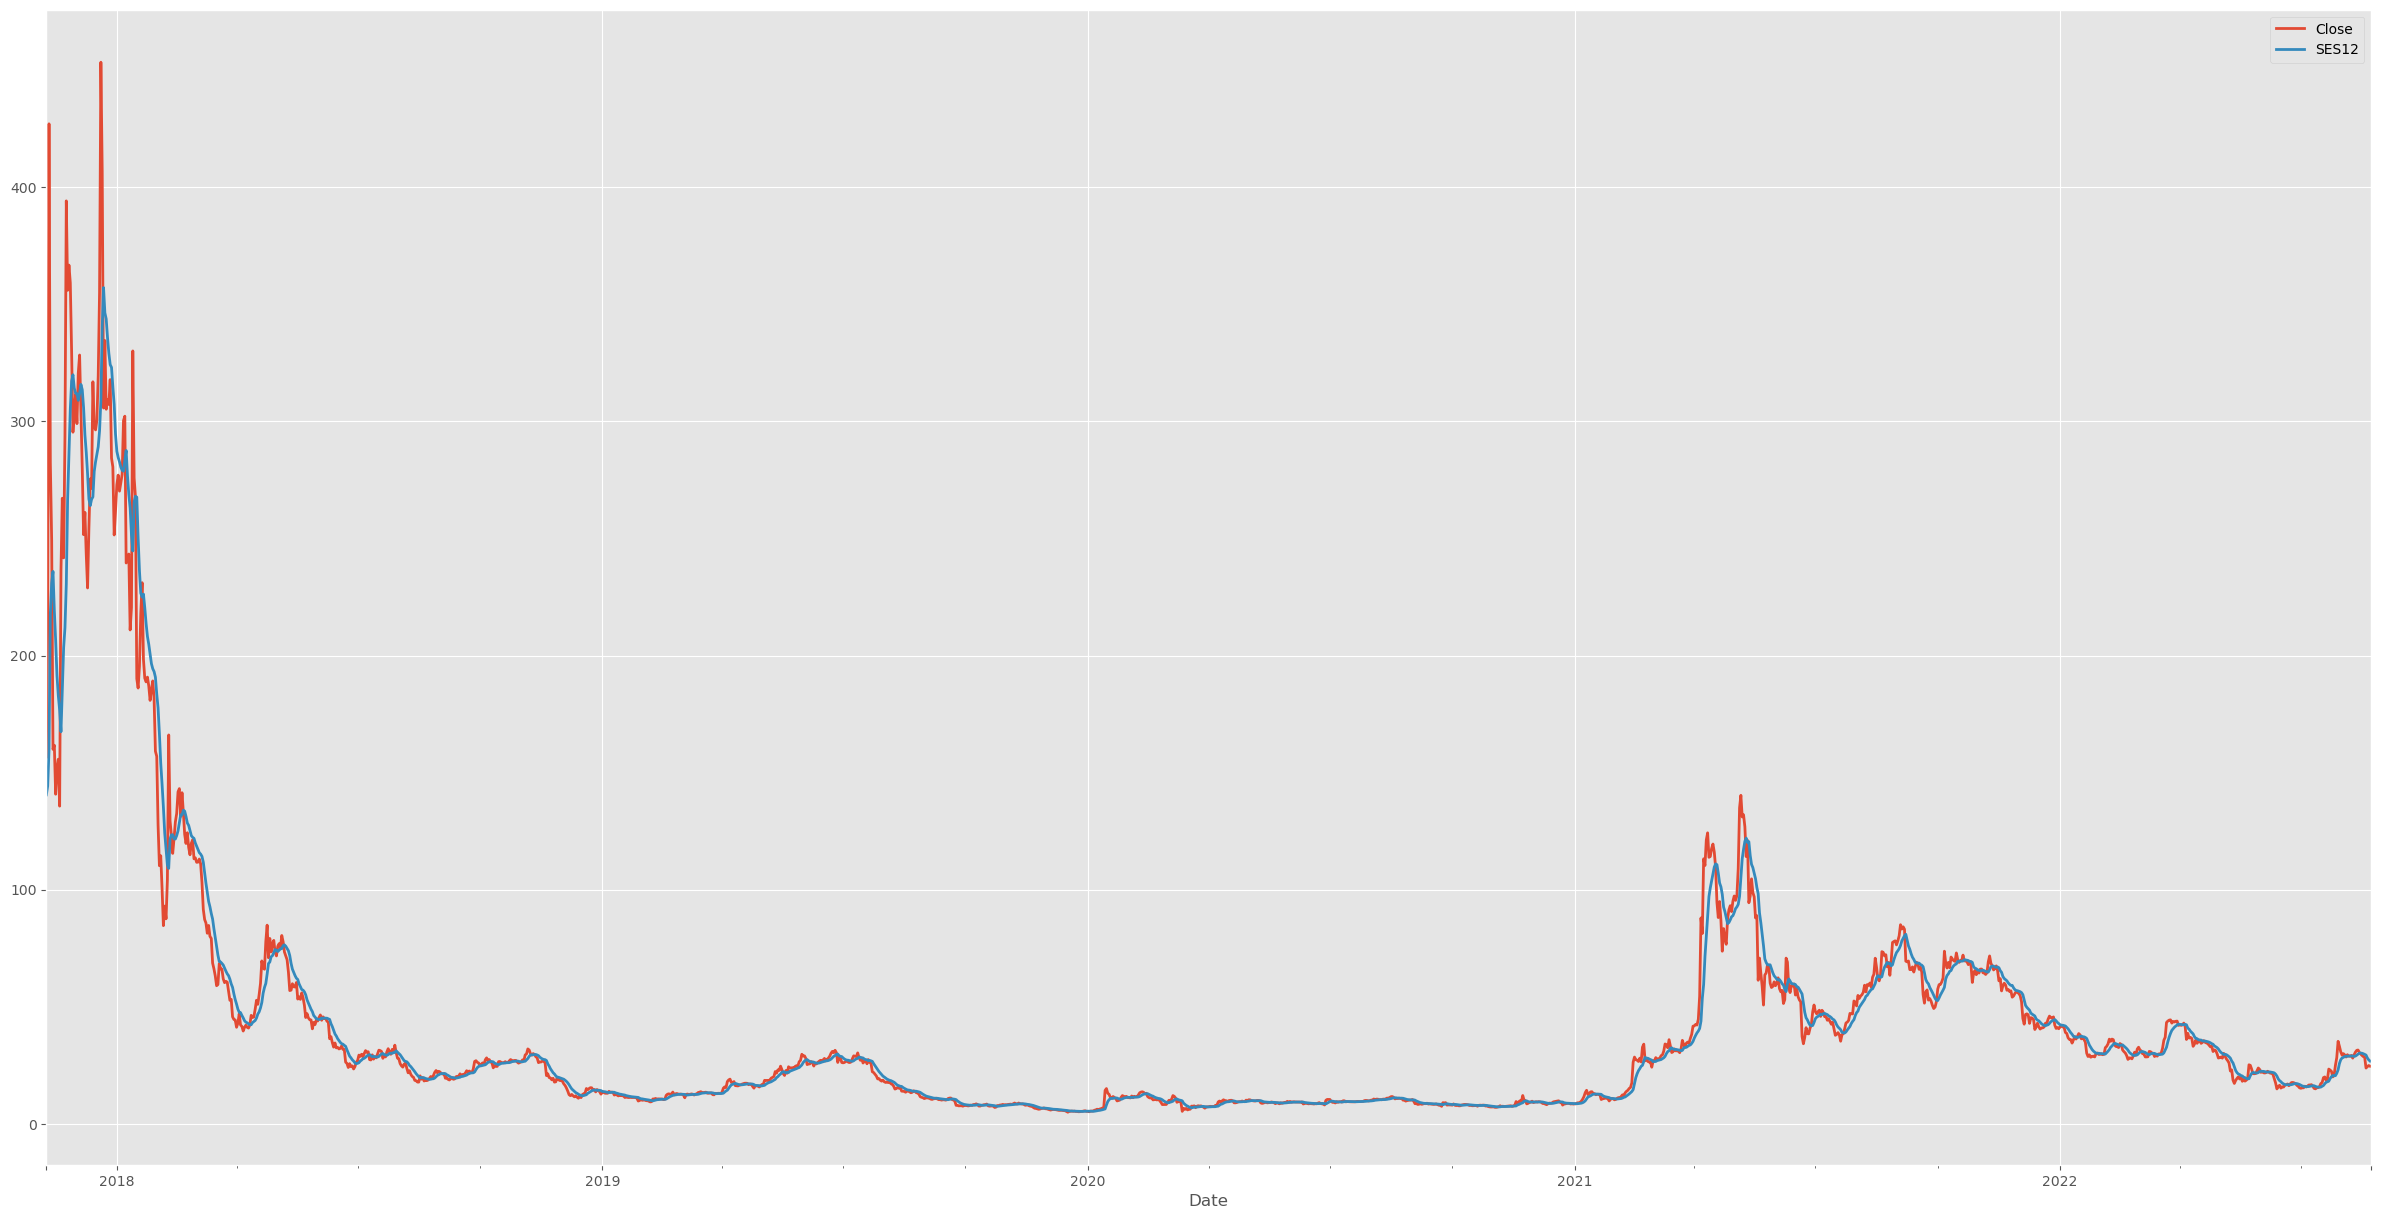

In [91]:
df[['Close','SES12']].plot(figsize=(30,15)).autoscale(axis='x', tight=True)

In [92]:
df['DESadd12'] = ExponentialSmoothing(df['Open'], trend='add').fit().fittedvalues.shift(-1)

In [93]:
df.head()

Open        High         Low       Close       Volume  \
Date                                                                      
2017-11-09  140.514008  156.664993  138.231003  156.664993   13140500.0   
2017-11-10  157.490005  213.403000  155.391998  213.403000   36198500.0   
2017-11-11  213.123993  509.811005  213.123993  427.135010  187191008.0   
2017-11-12  421.750000  465.618011  281.545013  282.407013   90339904.0   
2017-11-13  277.002991  307.259003  218.339005  249.220993   45916500.0   

               Total Pov  Daily Return  6-month-SMA  12-month-SMA  \
Date                                                                
2017-11-09  1.314109e+07           NaN          NaN           NaN   
2017-11-10  3.619924e+07      1.754660          NaN           NaN   
2017-11-11  1.871924e+08      4.171169          NaN           NaN   
2017-11-12  9.034136e+07     -0.517388          NaN           NaN   
2017-11-13  4.591755e+07     -0.491733          NaN           NaN   

            2-month-SMA     EWM-A12       SES12    DESadd12  
Date                                                         
2017-11-09          NaN  140.514008  140.514008  151.883287  
2017-11-10   149.002007  144.286452  144.286452  156.159894  
2017-11-11   185.306999  159.583683  159.583683  206.946606  
2017-11-12   317.436996  217.842865  217.842865  401.609411  
2017-11-13   349.376495  230.989559  230.989559  294.818547

<AxesSubplot:xlabel='Date'>

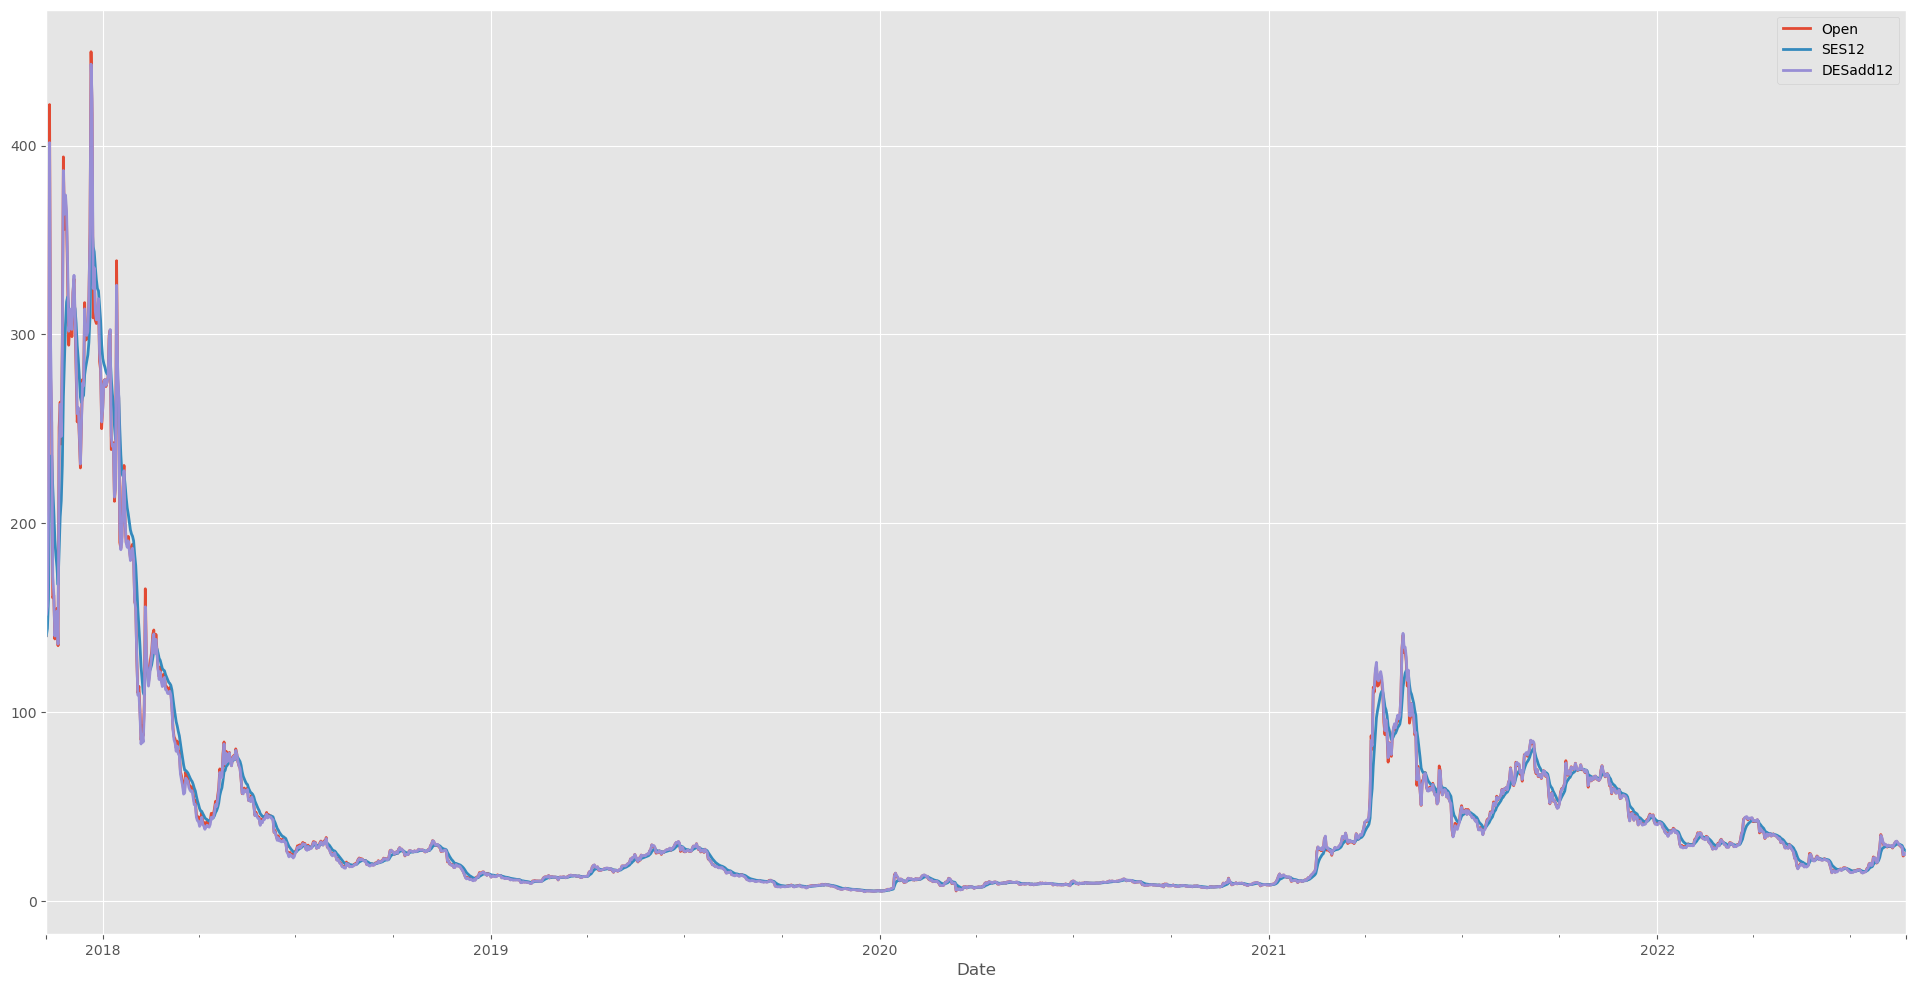

In [94]:
df[['Open', 'SES12', 'DESadd12']].plot(figsize=(24,12))

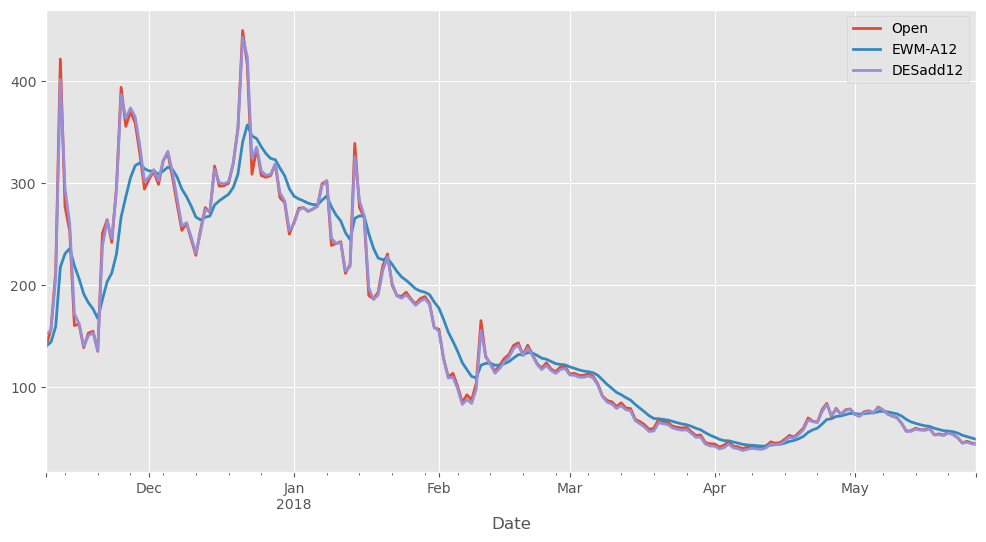

In [95]:
df[['Open', 'EWM-A12', 'DESadd12']].iloc[:200].plot(figsize=(12,6)).autoscale(axis='x', tight = True);

In [96]:
df['DESmul-12'] = ExponentialSmoothing(df['Open'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

Open        High         Low       Close       Volume  \
Date                                                                      
2017-11-09  140.514008  156.664993  138.231003  156.664993   13140500.0   
2017-11-10  157.490005  213.403000  155.391998  213.403000   36198500.0   
2017-11-11  213.123993  509.811005  213.123993  427.135010  187191008.0   
2017-11-12  421.750000  465.618011  281.545013  282.407013   90339904.0   
2017-11-13  277.002991  307.259003  218.339005  249.220993   45916500.0   

               Total Pov  Daily Return  6-month-SMA  12-month-SMA  \
Date                                                                
2017-11-09  1.314109e+07           NaN          NaN           NaN   
2017-11-10  3.619924e+07      1.754660          NaN           NaN   
2017-11-11  1.871924e+08      4.171169          NaN           NaN   
2017-11-12  9.034136e+07     -0.517388          NaN           NaN   
2017-11-13  4.591755e+07     -0.491733          NaN           NaN   

            2-month-SMA     EWM-A12       SES12    DESadd12   DESmul-12  
Date                                                                     
2017-11-09          NaN  140.514008  140.514008  151.883287  148.794603  
2017-11-10   149.002007  144.286452  144.286452  156.159894  154.568914  
2017-11-11   185.306999  159.583683  159.583683  206.946606  204.233281  
2017-11-12   317.436996  217.842865  217.842865  401.609411  393.705348  
2017-11-13   349.376495  230.989559  230.989559  294.818547  286.406403

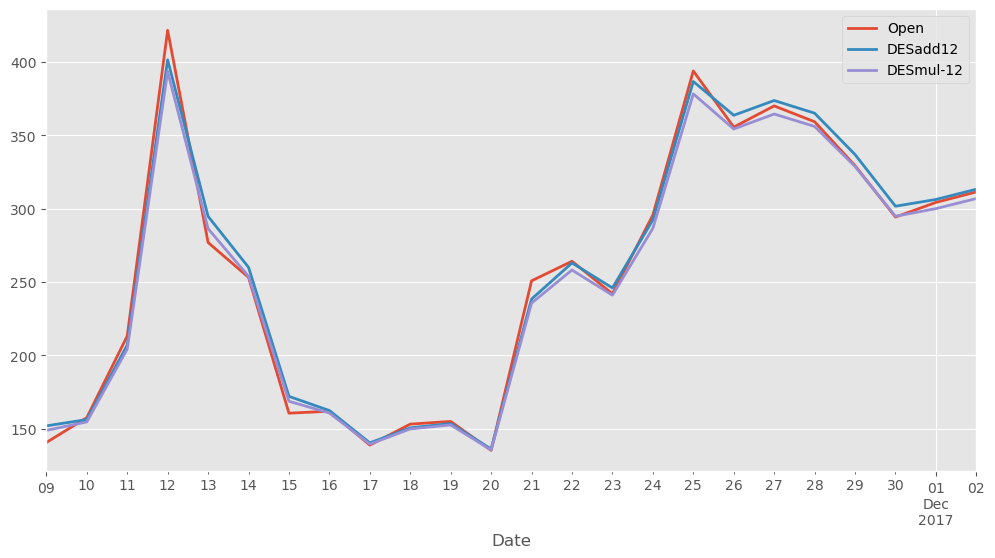

In [97]:
df[['Open','DESadd12','DESmul-12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x', tight = True);

In [98]:
df['TESadd12'] = ExponentialSmoothing(df['Open'], trend = 'add', seasonal = 'add', seasonal_periods =12).fit().fittedvalues

In [99]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Total Pov', 'Daily Return',
       '6-month-SMA', '12-month-SMA', '2-month-SMA', 'EWM-A12', 'SES12',
       'DESadd12', 'DESmul-12', 'TESadd12'],
      dtype='object')

In [100]:
df['TESmul-12'] = ExponentialSmoothing(df['Open'], trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues
df.head()

Open        High         Low       Close       Volume  \
Date                                                                      
2017-11-09  140.514008  156.664993  138.231003  156.664993   13140500.0   
2017-11-10  157.490005  213.403000  155.391998  213.403000   36198500.0   
2017-11-11  213.123993  509.811005  213.123993  427.135010  187191008.0   
2017-11-12  421.750000  465.618011  281.545013  282.407013   90339904.0   
2017-11-13  277.002991  307.259003  218.339005  249.220993   45916500.0   

               Total Pov  Daily Return  6-month-SMA  12-month-SMA  \
Date                                                                
2017-11-09  1.314109e+07           NaN          NaN           NaN   
2017-11-10  3.619924e+07      1.754660          NaN           NaN   
2017-11-11  1.871924e+08      4.171169          NaN           NaN   
2017-11-12  9.034136e+07     -0.517388          NaN           NaN   
2017-11-13  4.591755e+07     -0.491733          NaN           NaN   

            2-month-SMA     EWM-A12       SES12    DESadd12   DESmul-12  \
Date                                                                      
2017-11-09          NaN  140.514008  140.514008  151.883287  148.794603   
2017-11-10   149.002007  144.286452  144.286452  156.159894  154.568914   
2017-11-11   185.306999  159.583683  159.583683  206.946606  204.233281   
2017-11-12   317.436996  217.842865  217.842865  401.609411  393.705348   
2017-11-13   349.376495  230.989559  230.989559  294.818547  286.406403   

              TESadd12   TESmul-12  
Date                                
2017-11-09  165.359180  207.808900  
2017-11-10  135.008777  156.447636  
2017-11-11  130.166501  160.457517  
2017-11-12  227.079520  236.733432  
2017-11-13  373.953845  396.562764

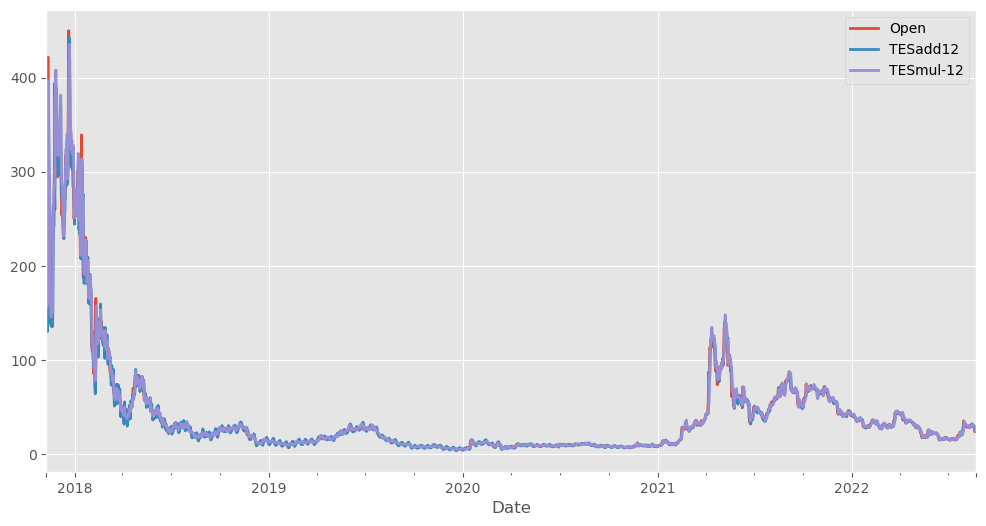

In [101]:
df[['Open', 'TESadd12', 'TESmul-12']].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

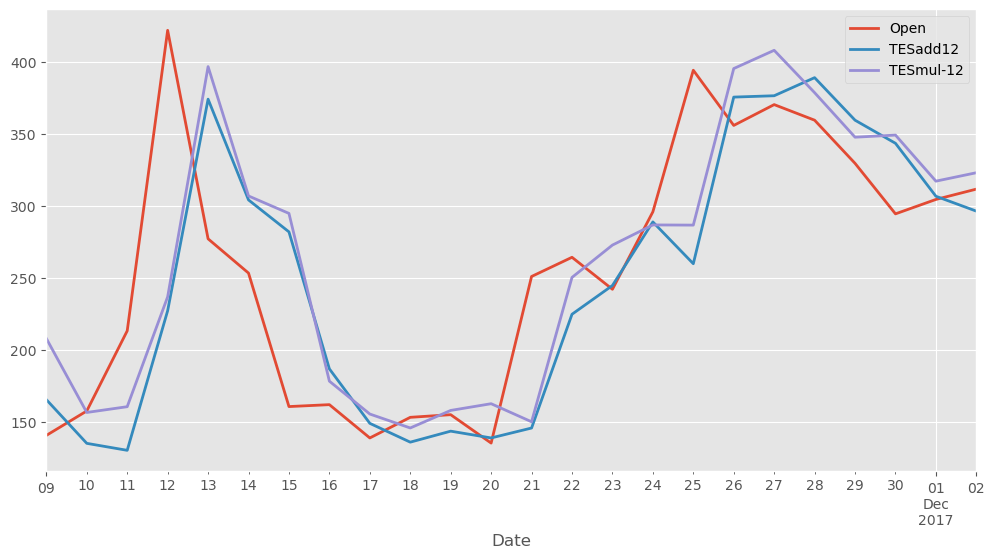

In [102]:
df[['Open', 'TESadd12', 'TESmul-12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

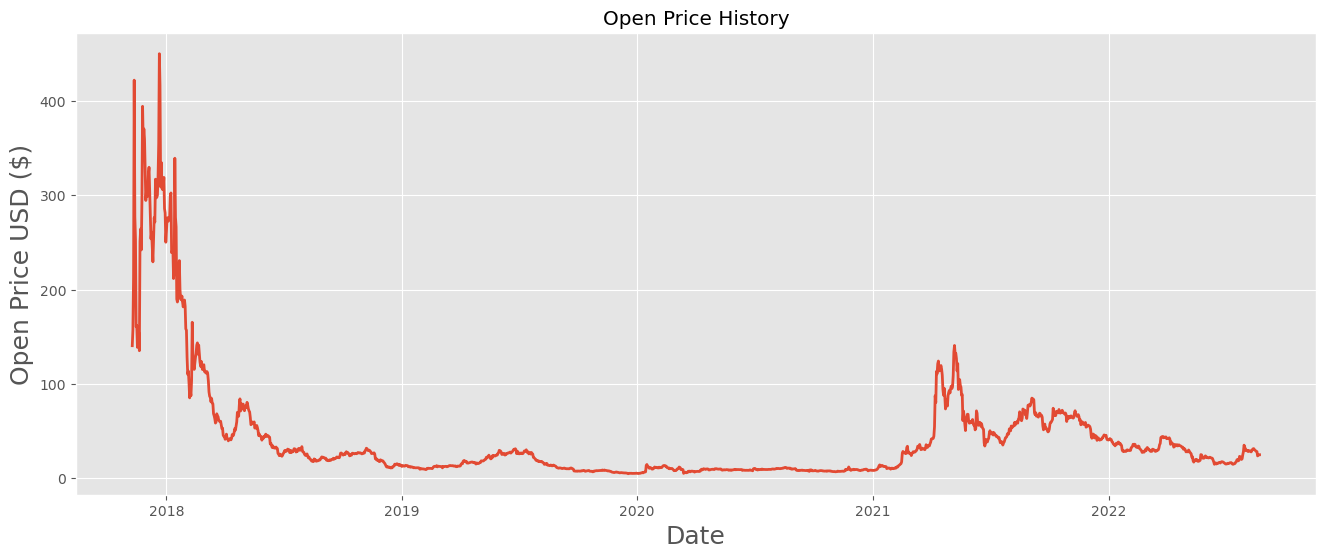

In [103]:
plt.figure(figsize=(16,6))
plt.title('Open Price History')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

# LSTM MODEL

In [105]:
#determining train set length
data = df.filter(['Open'])
dataset = data.values
training_data_len = int(np.ceil (len(dataset) * .80))
training_data_len

1400

In [106]:
#normalizing scale 0-1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data
scaled_data.shape

(1749, 1)

In [107]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.30480955, 0.34297362, 0.46804547, 0.93706164, 0.61165309,
       0.55817483, 0.34982813, 0.35282486, 0.30084612, 0.33304143,
       0.33718469, 0.2928563 , 0.55286028, 0.58282998, 0.53289697,
       0.65380532, 0.874773  , 0.78862278, 0.82112165, 0.79679026,
       0.72945679, 0.65060405, 0.67310321, 0.68922672, 0.66074528,
       0.7128387 , 0.72960519, 0.67607075, 0.61620778, 0.55928092,
       0.57532347, 0.53965035, 0.50446953, 0.56073319, 0.6096455 ,
       0.59911986, 0.70127441, 0.65675262, 0.65797108, 0.66334858,
       0.70788389, 0.78559686, 1.        , 0.92511515, 0.68303767,
       0.74102561, 0.68018251, 0.67646641, 0.68040734, 0.70557951,
       0.63136234, 0.62089962, 0.55121467, 0.57708825, 0.60808311,
       0.60967027, 0.60137697, 0.60620815, 0.61265351, 0.66244708])]
[0.6684833452974392]

[array([0.30480955, 0.34297362, 0.46804547, 0.93706164, 0.61165309,
       0.55817483, 0.34982813, 0.35282486, 0.30084612, 0.33304143,
       0.33718469, 0.2928563 , 0.552

In [108]:
x_train.shape

(1340, 60, 1)

In [109]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [110]:
x_test.shape

(349, 60, 1)

In [111]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(56, return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 56)                27104     
                                                                 
 dense (Dense)               (None, 16)                912       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 44,929
Trainable params: 44,929
Non-trainable params: 0
_________________________________________________________________


In [112]:
callbacks = [EarlyStopping(patience=4, monitor='loss', mode='min'),ReduceLROnPlateau(patience=3, verbose=1)]

In [161]:
history = model.fit(x_train, y_train,epochs=50, batch_size=32, callbacks=[callbacks],)

Epoch 1/50
42/42 [==============================] - 5s 48ms/step - loss: 0.0014 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 2s 57ms/step - loss: 5.6620e-04 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 2s 54ms/step - loss: 4.5982e-04 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 3s 66ms/step - loss: 4.6550e-04 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 3s 64ms/step - loss: 4.1710e-04 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - 3s 61ms/step - loss: 4.2826e-04 - lr: 0.0010
Epoch 7/50
42/42 [==============================] - 2s 58ms/step - loss: 4.3353e-04 - lr: 0.0010
Epoch 8/50
42/42 [==============================] - 2s 57ms/step - loss: 4.0765e-04 - lr: 0.0010
Epoch 9/50
42/42 [==============================] - 3s 60ms/step - loss: 3.2273e-04 - lr: 0.0010
Epoch 10/50
42/42 [==============================] - 2s 56ms/step - loss: 3.5594e-04 - lr: 0.0010
Epoch 11/50
42/42 [==============

42/42 [==============================] - 3s 64ms/step - loss: 2.6230e-04 - lr: 0.0010
Epoch 29/50
42/42 [==============================] - 3s 73ms/step - loss: 2.3362e-04 - lr: 0.0010
Epoch 30/50
42/42 [==============================] - 3s 66ms/step - loss: 2.3291e-04 - lr: 0.0010
Epoch 31/50
42/42 [==============================] - 2s 57ms/step - loss: 2.2506e-04 - lr: 0.0010
Epoch 32/50
42/42 [==============================] - 2s 59ms/step - loss: 2.4681e-04 - lr: 0.0010
Epoch 33/50
42/42 [==============================] - 2s 55ms/step - loss: 2.6685e-04 - lr: 0.0010
Epoch 34/50
42/42 [==============================] - 3s 61ms/step - loss: 2.6420e-04 - lr: 0.0010
Epoch 35/50
42/42 [==============================] - 3s 65ms/step - loss: 2.0903e-04 - lr: 0.0010
Epoch 36/50
42/42 [==============================] - 3s 63ms/step - loss: 2.1764e-04 - lr: 0.0010
Epoch 37/50
42/42 [==============================] - 3s 61ms/step - loss: 2.1400e-04 - lr: 0.0010
Epoch 38/50
42/42 [=============

In [162]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

preds = model.predict(x_test)
preds = scaler.inverse_transform(preds)

rmse = np.sqrt(np.mean(((preds - y_test)**2)))
print ('Root Mean Squared Error',rmse)
print ('Mean Absolute Error',mean_absolute_error(y_test, preds))

11/11 [==============================] - 1s 17ms/step
Root Mean Squared Error 2.7584150675495502
Mean Absolute Error 2.169766245735409


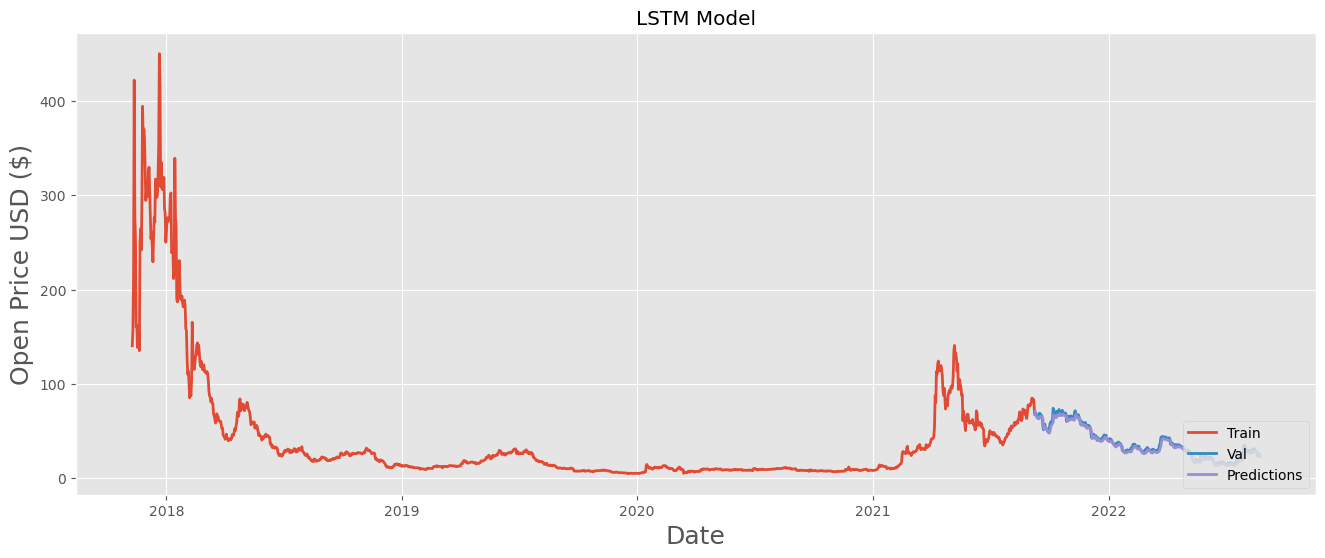

In [163]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds

plt.figure(figsize=(16,6))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

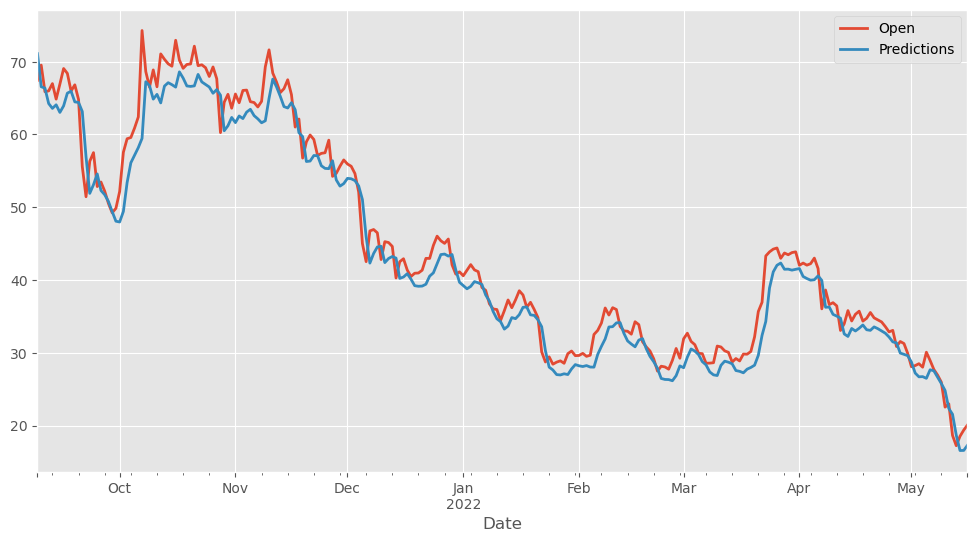

In [164]:
valid[['Open', 'Predictions']].iloc[:250].plot(figsize=(12,6)).autoscale(axis='x', tight = True);

# Gated Recurrent Unit (GRU)

In [147]:
model2 = Sequential()
model2.add(GRU(64, return_sequences=True, input_shape=(x_train.shape[1],1)))
model2.add(GRU(52, return_sequences=False))
model2.add(Dense(16))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(optimizer='rmsprop', loss='mean_squared_error',metrics='mean_squared_error')
model2.summary()

#model2.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mae','mse'])



Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_23 (GRU)                (None, 60, 64)            12864     
                                                                 
 gru_24 (GRU)                (None, 52)                18408     
                                                                 
 dense_36 (Dense)            (None, 16)                848       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32,137
Trainable params: 32,137
Non-trainable params: 0
_________________________________________________________________


In [148]:
model2.fit(x_train, y_train, epochs=40, batch_size=32,)

Epoch 1/40
42/42 [==============================] - 7s 48ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2/40
42/42 [==============================] - 2s 45ms/step - loss: 9.2782e-04 - mean_squared_error: 9.2782e-04
Epoch 3/40
42/42 [==============================] - 2s 45ms/step - loss: 8.0886e-04 - mean_squared_error: 8.0886e-04
Epoch 4/40
42/42 [==============================] - 2s 46ms/step - loss: 6.9710e-04 - mean_squared_error: 6.9710e-04
Epoch 5/40
42/42 [==============================] - 2s 45ms/step - loss: 7.1031e-04 - mean_squared_error: 7.1031e-04
Epoch 6/40
42/42 [==============================] - 2s 47ms/step - loss: 5.5217e-04 - mean_squared_error: 5.5217e-04
Epoch 7/40
42/42 [==============================] - 2s 49ms/step - loss: 6.3308e-04 - mean_squared_error: 6.3308e-04
Epoch 8/40
42/42 [==============================] - 2s 50ms/step - loss: 6.0042e-04 - mean_squared_error: 6.0042e-04
Epoch 9/40
42/42 [==============================] - 2s 48ms/step - loss:

In [149]:
preds_gru = model2.predict(x_test)
preds_gru = scaler.inverse_transform(preds_gru)

rmse = np.sqrt(np.mean(((preds_gru - y_test)**2)))
print ('Root Mean Squared Error',rmse)
print ('Mean Absolute Error',mean_absolute_error(y_test, preds_gru))

11/11 [==============================] - 1s 14ms/step
Root Mean Squared Error 2.429299125570963
Mean Absolute Error 1.7994910078950461


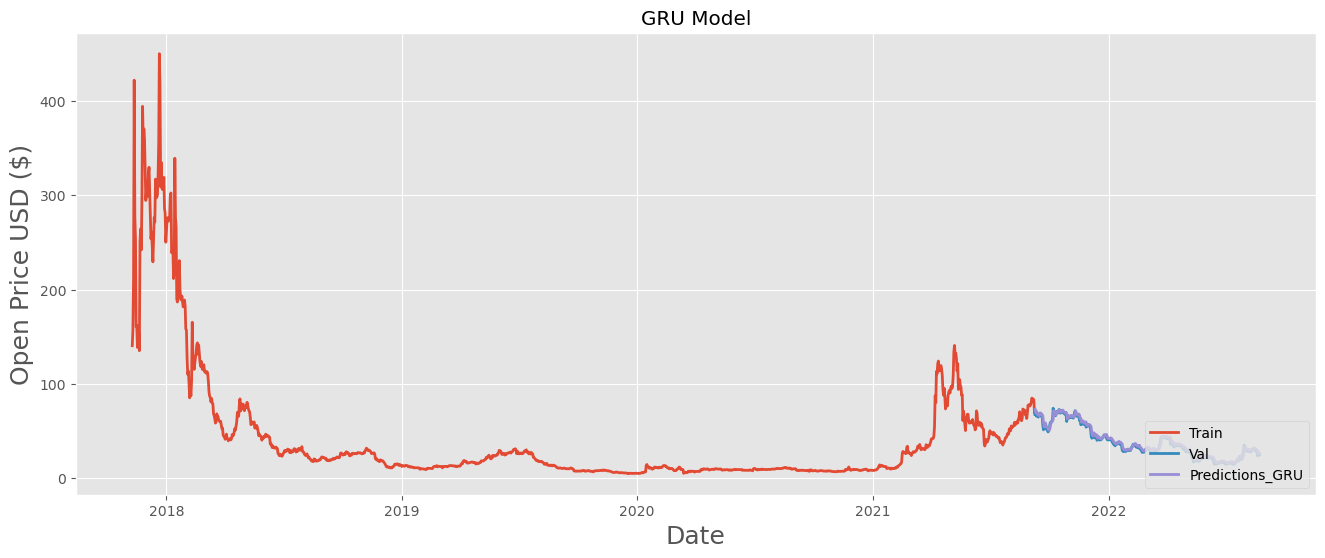

In [150]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions_GRU'] = preds_gru

plt.figure(figsize=(16,6))
plt.title('GRU Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions_GRU']])
plt.legend(['Train', 'Val', 'Predictions_GRU'], loc='lower right')
plt.show()

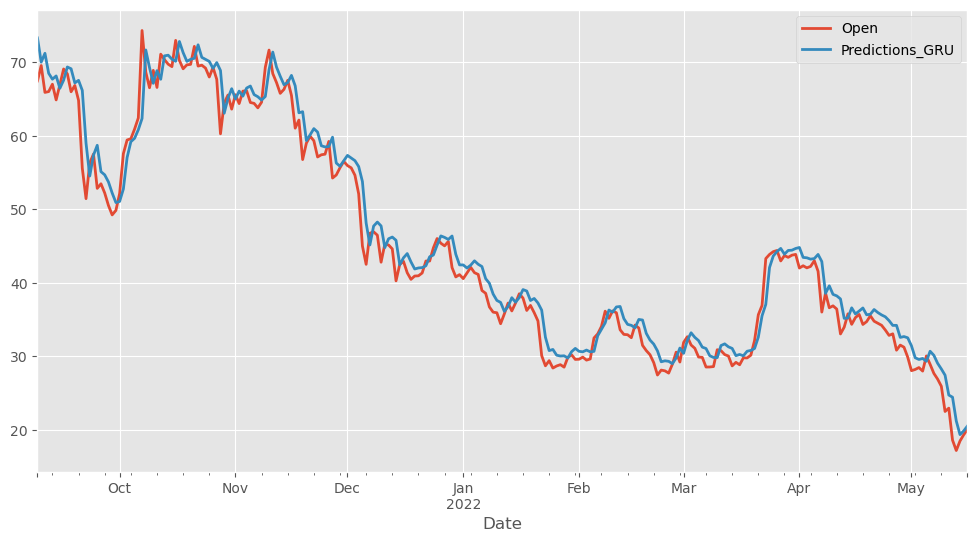

In [151]:
valid[['Open', 'Predictions_GRU']].iloc[:250].plot(figsize=(12,6)).autoscale(axis='x', tight = True);